In [149]:
import numpy as np
import transforms3d as tf
import matplotlib.pyplot as plt

In [150]:
data = np.genfromtxt('data/agent1/gyro-0.csv', delimiter=',')
data = np.delete(data, (0), axis=0)
acc_data = np.genfromtxt('data/agent1/accel-0.csv', delimiter=',')
acc_data = np.delete(acc_data, (0), axis=0) 
ref_euler = np.genfromtxt('data/agent1/ref_att_euler.csv', delimiter=',')
ref_euler = np.delete(ref_euler, (0), axis=0)
ref_pos = np.genfromtxt('data/agent1/ref_pos.csv', delimiter=',')
ref_pos = np.delete(ref_pos, (0), axis=0)
ref_euler.shape

(3000, 3)

In [151]:
def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

Text(0.5, 0, 'time [s]')

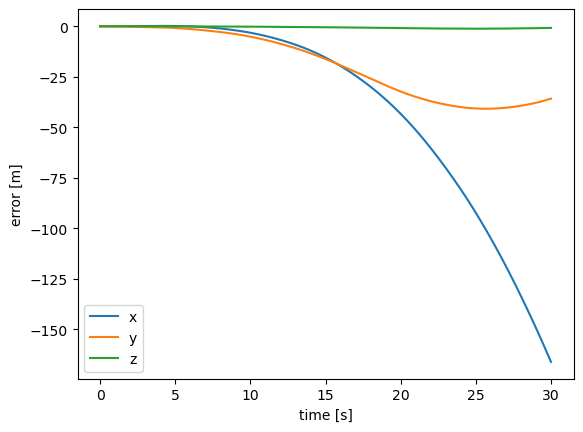

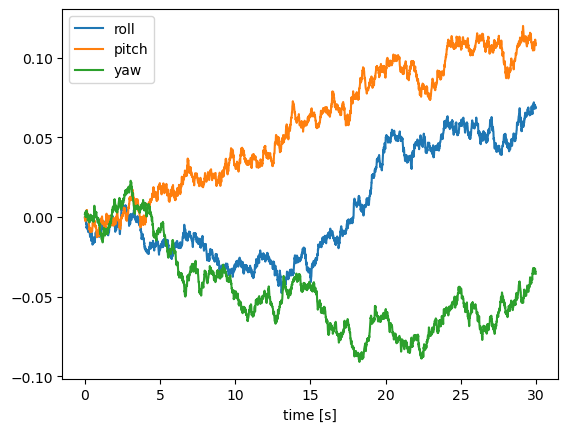

In [166]:
R_att = np.eye(3)
v = np.zeros(3)
p = ref_pos[0]
tau = 0.01
rec_err = []
rec_pos_err = []
rec_angles = []
g = np.array([0, 0, 9.794841972265039942e+00])
for i,w in enumerate(data):
    euler = np.array(tf.euler.mat2euler(R_att)) * 180 / np.pi
    error = euler - ref_euler[i]
    rec_err.append(error)
    skew_w = skew(w)
    R_att_prev = R_att.copy()
    accel = acc_data[i]
    R_att = R_att @ (np.eye(3) + skew_w * tau + .5 * skew_w**2 * tau**2)
    angles = tf.euler.mat2euler(R_att)
    rec_angles.append(angles)
    f = .5 * (R_att_prev + R_att) @ accel
    a = f + g
    v_prev = v.copy()
    v = v + a * tau # second order power series
    p = p +  .5 * (v + v_prev) * tau
    pos_error = p - ref_pos[i]
    rec_pos_err.append(pos_error)
time = np.arange(0, len(data) / 100, tau)
plt.plot(time, rec_pos_err)
plt.legend(['x', 'y', 'z'])
plt.xlabel('time [s]')
plt.ylabel('error [m]')
plt.figure()
plt.plot(time,rec_angles)
plt.legend(['roll', 'pitch', 'yaw'])
plt.xlabel('time [s]')

In [154]:
from sympy import Matrix, eye, cos, sin, pi, symbols, latex
from scipy.linalg import block_diag

In [155]:
# symbolic euler angles
phi, theta, psi, dt = symbols('phi theta psi {\Delta}t') 

# angular vector
w = Matrix([[phi],
            [theta],
            [psi]])

# rotation matrix
R = Matrix([[cos(theta), 0, -cos(phi)*sin(theta)],
            [0 , 1, sin(phi)],
            [sin(theta), 0, cos(phi)*cos(theta)]])
Rdt = Matrix([[cos(theta)*dt, 0, -cos(phi)*sin(theta)],
            [0 , dt, sin(phi)],
            [sin(theta), 0, dt*cos(phi)*cos(theta)]])

B = Matrix([[1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]])
Bdt = Matrix([[dt, 0, 0],
            [0, dt, 0],
            [0, 0, dt]])
Bdt @ R @ w == (B @ R * dt @ w)

In [180]:
dt = 0.01
I = np.eye(3)
Idt = np.eye(3) * dt
Idt2 = .5 * np.eye(3) * dt**2
F = block_diag(I, I, I)
F[0:3, 3:6] = Idt
print(F)
B = np.zeros((9,6))
B[0:3, 0:3] = Idt2
B[3:6, 0:3] = Idt
B[6:9, 3:6] = Idt
print(B)
C = np.zeros((2,9))
C[0, 6] = 1
C[1, 7] = 1
print(C)

[[1.   0.   0.   0.01 0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.01 0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.01 0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]
[[5.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 5.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 5.e-05 0.e+00 0.e+00 0.e+00]
 [1.e-02 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-02 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-02 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-02 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-02 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-02]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]


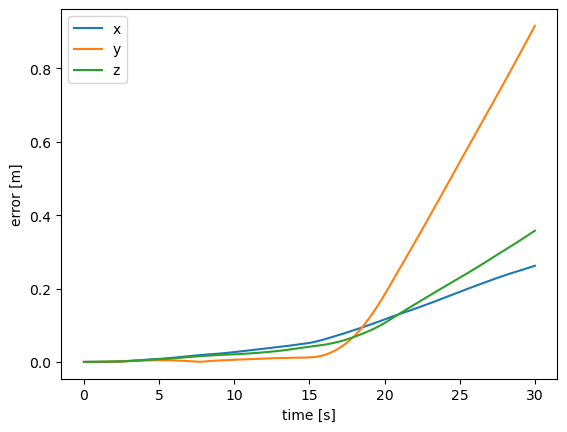

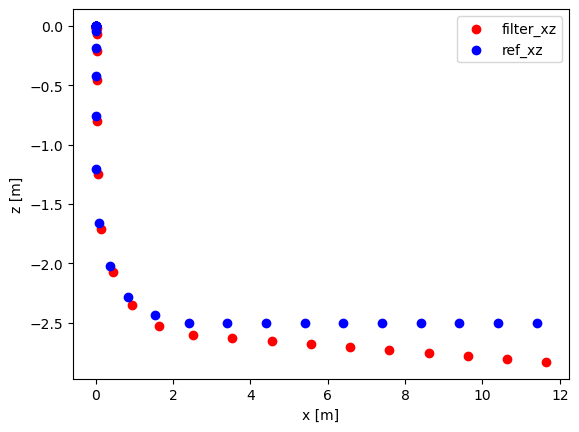

In [181]:
from filterpy.kalman import KalmanFilter
filter = KalmanFilter(dim_x=9, dim_z=2)
filter.x = np.array([ref_pos[0][0], ref_pos[0][1], ref_pos[0][2], 0, 0, 0, 0, 0, 0]).reshape(9,1)
filter.F = F
filter.B = B
filter.H = C
filter.P = np.eye(9)*1e+3
filter.R = np.eye(2)*1e-2
filter.Q = np.eye(9)*1e-1
R_att = np.eye(3)

rec_err = []
rec_filter_pos = []
rec_pos = []
for i,(acc,domega) in enumerate(zip(acc_data, data)):
    R_att = tf.euler.euler2mat(filter.x[6], filter.x[7], filter.x[8], axes='sxyz')
    phi = np.arctan2(acc[1], np.sqrt(acc[0]**2 + acc[2]**2))
    theta = np.arctan2(acc[0], np.sqrt(acc[1]**2 + acc[2]**2))
    z = np.array([phi, theta]).reshape(2,1)
    acc = acc + g
    u = np.concatenate((R_att @ acc, R_att @ domega)).reshape(6,1)
    filter.predict(u=u)
    filter.update(z)
    rec_err.append(abs(filter.x[:3] - ref_pos[i].reshape(3,1)).reshape(3,))
    rec_filter_pos.append(filter.x[:3].reshape(3,))
    rec_pos.append(ref_pos[i].reshape(3,))

time = np.arange(len(data)) * dt
plt.plot(time, rec_err)
plt.legend(['x', 'y', 'z'])
plt.xlabel('time [s]')
plt.ylabel('error [m]')
plt.figure()
rec_filter_pos = np.array(rec_filter_pos) - rec_pos[0]
rec_pos = np.array(rec_pos) - rec_pos[0]
plt.scatter(rec_filter_pos[::100,0], rec_filter_pos[::100,2], c='r')
plt.scatter(rec_pos[::100,0], rec_pos[::100,2], c='b')
plt.legend(['filter_xz', 'ref_xz'])
plt.xlabel('x [m]')
at = plt.ylabel('z [m]')